In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import randrange
import random
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams.update({'font.size': 22})

# Task 2 Compete in a kaggle competition to predict Titanic Survival

#### SibSp
number of siblings/spouses on board<br>
Sibling = brother sister stepbrother stepsister<br>
spouse = husband, wife (mistresses and fiancés were ignored)

#### Parch
number of parents/children<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
some children travelled only with a nanny, parch=0 for them

#### Class
proxy for socio-economic status 1=upper, 2=middle, 3=lower

#### Survived
1 = Yes, 0 = No

#### Embarked
C = Cherbourg, Q=Queenstown, S=Southampton

### Task 2A: Preparation

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

display(train_df.head())
display(test_df.head())
display(train_df.describe())
display(test_df.describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### Plotjes

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


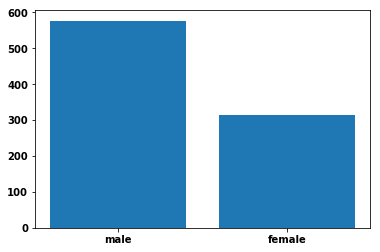

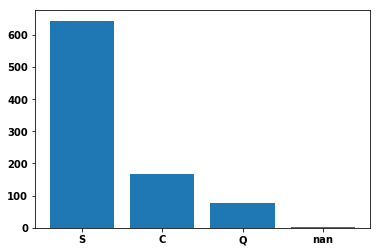

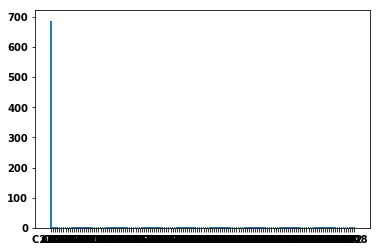

In [3]:
import os
if not os.path.exists('results/titanic/'):
    os.makedirs('results/titanic/')
    
from collections import Counter


def show_save_histogram(df, column_name):
    """ Makes and saves a histogram of a specific df column. """
    train_df.hist(column=column_name)
    plt.savefig("results/titanic/" + column_name + ".png")

def make_bar_chart(df, column_name):
    """ Makes a bar chart given a data frame column. """
    
    freqs = Counter(df[column_name])
    xvals = range(len(freqs.values()))
    
    plt.figure()
    plt.bar(xvals, freqs.values())
    plt.xticks(xvals, freqs.keys())
    
    plt.savefig("results/titanic/" + column_name + ".png")


make_bar_chart(train_df, "Sex")
make_bar_chart(train_df, "Embarked")
make_bar_chart(train_df, "Cabin")

        Survived  Died
Sex                   
female       233    81
male         109   468


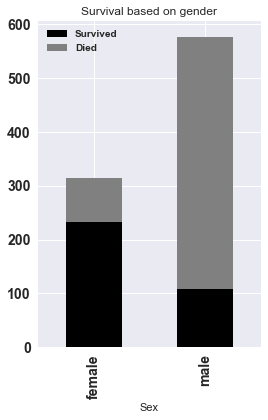

In [4]:
train_df['Died'] = 1 - train_df['Survived']
alldata = train_df.groupby('Sex').agg('sum')[['Survived', 'Died']]
plt.style.use('seaborn')

print(alldata)
plot = train_df.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', 
                                                                    fontsize=14, 
                                                                    figsize=(4, 6),
                                                                    stacked=True, 
                                                                    color=['black', 'grey'],
                                                                    title="Survival based on gender");
plot.figure.savefig("results/gender.pdf")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


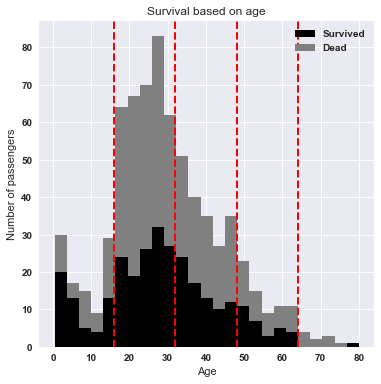

In [5]:
# g = sns.FacetGrid(train_df, col='Survived', height=5, aspect=.9, col_order=[1, 0])
# g.map(plt.hist, 'Age', bins=25, color='black')
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Survival based on age', fontsize=16)
# g.savefig("results/age")

data = train_df
figure = plt.figure(figsize=(6, 6))
plt.hist([data[data['Survived'] == 1]['Age'], data[data['Survived'] == 0]['Age']], 
         stacked=True, color = ['black','grey'],
         bins = 25, label = ['Survived','Dead'])
plt.title('Survival based on age')
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.legend();
plt.axvline(x=16, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=32, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=48, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=64, color='r', linestyle='dashed', linewidth=2)
plt.savefig("results/agestacked.pdf")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


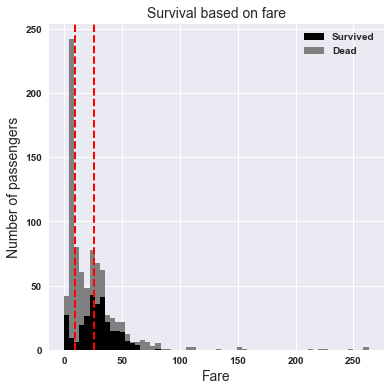

In [6]:
data = train_df
figure = plt.figure(figsize=(6, 6))
plt.hist([data[data['Survived'] == 1]['Age'], data[data['Survived'] == 0]['Fare']], 
         stacked=True, 
         color = ['black','grey'],
         bins = 60, 
         label = ['Survived','Dead'])
plt.title('Survival based on fare', fontsize=14)
plt.xlabel('Fare',  fontsize=14)
plt.ylabel('Number of passengers',  fontsize=14)
plt.axvline(x=9, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=26, color='r', linestyle='dashed', linewidth=2)
plt.legend();
plt.savefig("results/farestacked.pdf")

### Task 2B: Classification and Evaluation

#### Random solution

In [7]:
# Random solution to titanic kaggle competition

# Create basis for dataframe
random_data = {'PassengerId': [], 'Survived':[]}

# Iterate over test data
for index,row in test_df.iterrows():

    # Append Passenger ID
    random_data['PassengerId'].append(row['PassengerId'])
    
    # Append random survival value from (0,1)
    random_data['Survived'].append(randrange(2))

# Make pandas dataframe
df_random_solution = pd.DataFrame(random_data)

# Save solution as csv
df_random_solution.to_csv('results/randomsol.csv', index=False)

#### Non-random solution

In [8]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# Trainingset: Preprocess data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### It is clear that some data is missing for 'age', 'cabin' and 'embarked'. Cabin has too little data, so it is dropped from the dataset. Name and ticket seem to not be relevant.

In [9]:
# Drop from training and test set
try: 
    train_df = train_df.drop(['Ticket', 'Cabin', 'Name'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin', 'Name'], axis=1)
except KeyError:
    print("Already deleted columns")
train_df.head(15)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
5,6,0,3,male,NaN,0,0,8.4583,Q
6,7,0,1,male,54.0,0,0,51.8625,S
7,8,0,3,male,2.0,3,1,21.0750,S
8,9,1,3,female,27.0,0,2,11.1333,S
9,10,1,2,female,14.0,1,0,30.0708,C


#### From the plots of survived people in a specific age category, it seems that the most people between 20 and 30 did not survive. 

In [10]:
# Obtain 4 category's for age
train_df['age_category'] = pd.cut(train_df['Age'], 5)

# Fill missing value with mean age
mean_age = train_df.Age.dropna().mean()
train_df.Age.fillna(mean_age, inplace=True)
test_df.Age.fillna(mean_age, inplace=True)

# Change in both datasets
train_df.loc[ train_df['Age'] <= 16, 'Age'] = 0
train_df.loc[(train_df['Age'] > 16) & (train_df['Age'] <= 32), 'Age'] = 1
train_df.loc[(train_df['Age'] > 32) & (train_df['Age'] <= 48), 'Age'] = 2
train_df.loc[(train_df['Age'] > 48) & (train_df['Age'] <= 64), 'Age'] = 3
train_df.loc[ train_df['Age'] > 64, 'Age'] = 4

test_df.loc[ test_df['Age'] <= 16, 'Age'] = 0
test_df.loc[(test_df['Age'] > 16) & (test_df['Age'] <= 32), 'Age'] = 1
test_df.loc[(test_df['Age'] > 32) & (test_df['Age'] <= 48), 'Age'] = 2
test_df.loc[(test_df['Age'] > 48) & (test_df['Age'] <= 64), 'Age'] = 3
test_df.loc[ test_df['Age'] > 64, 'Age'] = 4

train_df.head(10)

# Drop age category from dataframe
train_df.drop(columns=['age_category'], axis=1, inplace=True)

In [11]:
# Convert sex to only have zeros and ones
train_df['Sex'] = train_df['Sex'].map({'female': 1, 'male': 0})
test_df['Sex'] = test_df['Sex'].map({'female': 1, 'male': 0})

train_df.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,1.0,1,0,7.2500,S
1,2,1,1,1,2.0,1,0,71.2833,C
2,3,1,3,1,1.0,0,0,7.9250,S
3,4,1,1,1,2.0,1,0,53.1000,S
4,5,0,3,0,2.0,0,0,8.0500,S


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Died
0,1,0,3,0,1.0,1,0,7.2500,0,1
1,2,1,1,1,2.0,1,0,71.2833,1,0
2,3,1,3,1,1.0,0,0,7.9250,0,0
3,4,1,1,1,2.0,1,0,53.1000,0,0
4,5,0,3,0,2.0,0,0,8.0500,0,1


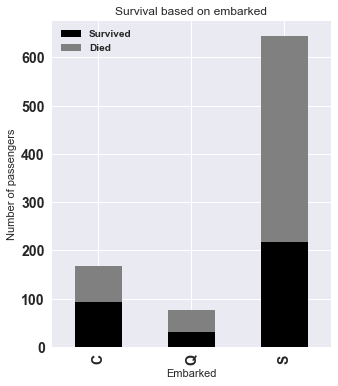

In [12]:
# Preprocess embarked
train_df['Died'] = 1 - train_df['Survived']
alldata = train_df.groupby('Embarked').agg('sum')[['Survived', 'Died']]

plt.style.use('seaborn')
plot = train_df.groupby('Embarked').agg('sum')[['Survived', 'Died']].plot(kind='bar', 
                                                                    fontsize=14, 
                                                                    figsize=(5, 6),
                                                                    stacked=True, 
                                                                    color=['black', 'grey'],
                                                                    title="Survival based on embarked");
plot.set_ylabel("Number of passengers")
plot.figure.savefig("results/embarked.pdf")

# Get mode for missing values
mode = train_df.Embarked.dropna().mode()[0]

 # Fill missing values with mode
train_df['Embarked'] = train_df['Embarked'].fillna(mode)
test_df['Embarked'] = test_df['Embarked'].fillna(mode)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Convert to integers
try:
    train_df['Embarked'] = train_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    test_df['Embarked'] = test_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
except ValueError:
    print("Already converted to int")

train_df.head()



#### Process fare information

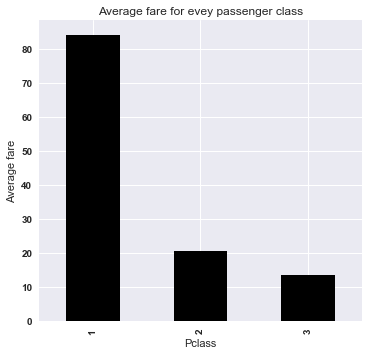

In [13]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Fare', bins=20, color="black")

ax = plt.subplot()
ax.set_ylabel('Average fare')
ax.set_title('Average fare for evey passenger class')
train_df.groupby('Pclass').mean()['Fare'].plot(kind='bar', 
                                               figsize=(5, 6), 
                                               ax = ax,
                                               color="black");
ax.figure.savefig("fare_pclass.pdf")

#### It seems like survivalrate is small when fare rate was little and that survival rate is higher when fare rate is very high. 

In [14]:
# First, fill in missing values with the median
median_fare = test_df['Fare'].dropna().median()
test_df['Fare'].fillna(median_fare, inplace=True)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 3)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

# Categorize
train_df.loc[ (train_df['Fare'] <= 8.662) & (train_df['Fare'] > 0.0), 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 8.662) & (train_df['Fare'] <= 26.0), 'Fare'] = 1
train_df.loc[ train_df['Fare'] > 26.0, 'Fare'] = 3

test_df.loc[ (test_df['Fare'] <= 8.662) & (test_df['Fare'] > 0.0), 'Fare'] = 0
test_df.loc[(test_df['Fare'] > 8.662) & (test_df['Fare'] <= 26.0), 'Fare'] = 1
test_df.loc[ test_df['Fare'] > 26.0, 'Fare'] = 3

# Drop fareband from dataset
train_df = train_df.drop(['FareBand'], axis=1)

In [15]:
train_df['Fare*Class'] = train_df.Age * train_df.Pclass
test_df['Fare*Class'] = test_df.Age * test_df.Pclass

train_df.loc[:, ['Fare*Class', 'Fare', 'Pclass']].head(10)

,Fare*Class,Fare,Pclass
0,3.0,0.0,3
1,2.0,3.0,1
2,3.0,0.0,3
3,2.0,3.0,1
4,6.0,0.0,3
5,3.0,0.0,3
6,3.0,3.0,1
7,0.0,1.0,3
8,3.0,1.0,3
9,0.0,3.0,2


In [16]:
for column in train_df:
    train_df[column].astype(int)

train_df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Died,Fare*Class
0,1,0,3,0,1.0,1,0,0.0,0,1,3.0
1,2,1,1,1,2.0,1,0,3.0,1,0,2.0
2,3,1,3,1,1.0,0,0,0.0,0,0,3.0
3,4,1,1,1,2.0,1,0,3.0,0,0,2.0
4,5,0,3,0,2.0,0,0,0.0,0,1,6.0
5,6,0,3,0,1.0,0,0,0.0,2,1,3.0
6,7,0,1,0,3.0,0,0,3.0,0,1,3.0
7,8,0,3,0,0.0,3,1,1.0,0,1,0.0
8,9,1,3,1,1.0,0,2,1.0,0,0,3.0
9,10,1,2,1,0.0,1,0,3.0,1,0,0.0


In [ ]:
X_train = train_df.drop("Survived", axis=1).copy()
X_train = X_train.drop("Died", axis=1).copy()
X_train = X_train.drop("PassengerId", axis=1).copy()
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

In [20]:
# Random forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = random_forest.score(X_train, Y_train) * 100
acc_random_forest

87.31762065095398

In [28]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = logreg.score(X_train, Y_train) * 100
acc_log


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


79.2368125701459